# 프로젝트: 데이터 증강 기법 (CutMix, Mixup) 비교 실험

개요:  

다음 4가지 경우의 데이터 증강 처리 기법이 이미지 분류 모델의 성능에 미치는 영향 비교 분석  
- No Augmentation
- Basic Augmentation
- Basic + Mixup
- Basic + CutMix

데이터셋: Stanford Dogs  

모델: Pre-trained ResNet-50  

성능 평가 방식: 견종 분류 정확도 (Top 1, Top 5)

## 1. 라이브러리 불러오기 & 경로 설정

In [1]:
# Pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.amp import GradScaler, autocast # 학습 속도 가속

# Helper libraries
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import scipy.io # .mat 파일을 읽기 위해 필요
import random
import time # 에폭별 학습 시간 측정을 위해 필요

In [2]:
# 이미지 데이터 압축 파일 경로
LISTS_TAR_PATH = './lists.tar'
DOGS_TAR_PATH = './stanford_dogs.tar' 

# 압축을 해제할 대상 디렉토리
EXTRACT_PATH = './stanford_dogs' 

# 데이터셋 클래스에서 참조할 최종 경로 설정
IMAGES_DIR = os.path.join(EXTRACT_PATH, 'Images') 
LISTS_DIR = os.path.join(EXTRACT_PATH, 'lists')

# TRAIN/TEST 파일의 전체 경로
TRAIN_LIST_PATH = os.path.join(LISTS_DIR, 'train_list.mat')
TEST_LIST_PATH = os.path.join(LISTS_DIR, 'test_list.mat')

# 모델 저장 경로
SAVE_DIR = './checkpoints'

# 필요한 폴더 미리 생성
os.makedirs(IMAGES_DIR, exist_ok=True) # 이미지 폴더
os.makedirs(LISTS_DIR, exist_ok=True) # 리스트 폴더
os.makedirs('./checkpoints', exist_ok=True) # 모델 저장 경로

## 2. 함수 & 클래스 정의

### 2-1. 함수 정의

In [3]:
def extract_data(tar_file_path, folder_name, extract_to, prefix=''): # 기본 prefix를 ''로 변경
    target_dir = os.path.join(extract_to, folder_name)

    if not os.path.exists(target_dir) or not os.listdir(target_dir):
        print(f"📦 압축 해제 중: {tar_file_path} -> {target_dir}")

        if not os.path.exists(tar_file_path):
            print(f"❌ 오류: {tar_file_path} 파일이 없습니다.")
            return
        
        try:
            with tarfile.open(tar_file_path, 'r') as tar:
                members = []
                for member in tar.getmembers():
                    if member.path.startswith(prefix):
                        member.name = member.path.replace(prefix, '', 1)
                        members.append(member)
                
                #압축 해제 경로를 target_dir로 지정
                # 경고 메시지를 없애기 위해 filter='data'를 명시적으로 추가
                tar.extractall(path=target_dir, members=members, filter='data') 
            print(f"✅ {folder_name} 압축 해제 완료.")
        except Exception as e:
            print(f"❌ 오류 발생: {e}")
    else:
        print(f"ℹ️ {folder_name} 데이터가 이미 존재합니다. 건너뜁니다.")

In [4]:
def show_sample_images(data_dir, num_samples=5):
    # 클래스(견종) 폴더 목록 가져오기
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    plt.figure(figsize=(16, 4))
    
    for i in range(num_samples):
        # 랜덤 견종 및 이미지 선택
        random_class = random.choice(classes)
        class_path = os.path.join(data_dir, random_class)
        random_img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, random_img_name)
        
        # 이미지 로드 및 출력
        img = Image.open(img_path)
        breed_name = random_class.split('-', 1)[-1] # 'n02085620-Chihuahua' -> 'Chihuahua'
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"{breed_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
def denormalize(tensor):
    """
    시각화를 위한 역정규화(Denormalize) 함수
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (tensor * std + mean).clamp(0, 1)

In [6]:
# top-k accuracy 평가 지표 계산 함수
def accuracy(output, target, topk=(1, 5)):
    with torch.no_grad():
        maxk = max(topk)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        
         # soft label(mixup/cutmix)인 경우 인덱스로 변환
        if target.ndimension() > 1:
            target = target.argmax(dim=1)

        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        # 총 정답 개수 반환
        return [correct[:k].reshape(-1).float().sum(0) for k in topk]

In [7]:
# Mixup 기법 구현
def apply_mixup(images, labels, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(images.size(0))

    mixed_images = lam * images + (1 - lam) * images[index, :]
    
    # 수정: labels[index, :] -> labels[index] (1차원이므로)
    # 수정: 정수형 레이블을 연산을 위해 float으로 변환
    mixed_labels = lam * labels.float() + (1 - lam) * labels[index].float()
    
    return mixed_images, mixed_labels, lam

In [8]:
# CutMix 기법 구현
def apply_cutmix(images, labels, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(images.size(0))
    
    W, H = images.size(2), images.size(3)

    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)

    cx, cy = np.random.randint(W), np.random.randint(H)

    bbx1, bby1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    bbx2, bby2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)

    images[:, :, bbx1:bbx2, bby1:bby2] = images[index, :, bbx1:bbx2, bby1:bby2]
    
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))

    # 수정: labels[index, :] -> labels[index] 및 float 변환
    mixed_labels = lam * labels.float() + (1 - lam) * labels[index].float()
    
    return images, mixed_labels, lam

In [9]:
def run_experiment(exp_name, train_loader, val_loader, save_dir, aug_type=None, alpha=1.0):
    os.makedirs(save_dir, exist_ok=True)
    filename = f'best_model_{exp_name.replace(" ", "_")}.pth'
    save_path = os.path.join(save_dir, filename)
    print(f"\n🚀 Starting Experiment: {exp_name}")

    model = models.resnet50(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    history = {'top1': [], 'top5': [], 'loss': [], 'time': []}
    best_acc = 0.0
    
    # GradScaler 인스턴스 생성
    scaler = torch.amp.GradScaler('cuda')
    
    for epoch in range(EPOCHS):
        epoch_start_time = time.time() # 학습 시간 측정

        # Train
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            labels = labels.long() # labels 텐서의 타입을 torch.long (LongTensor)으로 변환
            
            # lam 기본값 초기화 (1.0 - 섞이지 않음)
            lam = 1.0
            
            # 증강 기법에 따라 원핫 인코딩 여부를 결정
            if aug_type in ['mixup', 'cutmix']:
                labels_oh = torch.nn.functional.one_hot(labels, NUM_CLASSES).float()
                if aug_type == 'mixup':
                    images, target, _ = apply_mixup(images, labels_oh, alpha)
                elif aug_type == 'cutmix':
                    images, target, _ = apply_cutmix(images, labels_oh, alpha)
            else:
                # No Aug, Basic Aug일 때는 원본 labels를 target으로 설정
                target = labels
                
            optimizer.zero_grad()
            
            # autocast 컨텍스트 매니저 안에서 순전파 실행 (AMP 적용)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, target)

            # 역전파 및 가중치 업데이트 시 scaler 사용
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update() 
            
            running_loss += loss.item() * images.size(0) 

        # Validation
        model.eval()
        t1_acc, t5_acc, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                acc1, acc5 = accuracy(outputs, labels)
                t1_acc += acc1.item()
                t5_acc += acc5.item()
                total += labels.size(0)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        current_loss = running_loss / len(train_loader.dataset)
        current_top1 = (t1_acc / total) * 100 # 전체 데이터 수로 나누기
        current_top5 = (t5_acc / total) * 100
        
        history['loss'].append(current_loss)
        history['top1'].append(current_top1)
        history['top5'].append(current_top5)
        history['time'].append(epoch_duration)
        
        print(f"Epoch [{epoch+1}/{EPOCHS}]: Loss {current_loss:.4f} | Top-1 {current_top1:.2f}% | Top-5 {current_top5:.2f}% | Time {epoch_duration:.1f}s")
        
        if current_top1 > best_acc:
            best_acc = current_top1
            torch.save(model.state_dict(), save_path)
            print(f"   >>> ★ New best model saved: {filename}")
        
    return history

In [10]:
def visualize_results(all_histories):
    """
    모든 실험 결과를 시각화하고 요약 표를 출력하는 함수
    """
    # 1. 요약 표 생성 (데이터프레임)
    summary_data = []
    for exp_name, hist in all_histories.items():
        summary_data.append({
            'Augmentation': exp_name,
            'Best Loss': min(hist['loss']),
            'Best Top-1 (%)': max(hist['top1']),
            'Best Top-5 (%)': max(hist['top5'])
        })
    
    df_summary = pd.DataFrame(summary_data)
    print("\n" + "="*60)
    print("📊 실험 결과 요약 (Summary Table)")
    print("="*60)
    print(df_summary.to_string(index=False))
    
    # 2. 그래프 시각화 (Loss, Top-1, Top-5)
    # 첫 번째 실험 결과의 길이를 기준으로 에폭 범위를 설정합니다.
    first_hist = next(iter(all_histories.values()))
    epochs = range(1, len(first_hist['top1']) + 1)
    
    plt.figure(figsize=(20, 6))

    # (1) Loss 그래프
    plt.subplot(1, 3, 1)
    for exp_name, hist in all_histories.items():
        plt.plot(epochs, hist['loss'], marker='o', markersize=4, label=exp_name)
    plt.title('Training Loss Comparison', fontsize=13, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # (2) Top-1 Accuracy 그래프
    plt.subplot(1, 3, 2)
    for exp_name, hist in all_histories.items():
        plt.plot(epochs, hist['top1'], marker='s', markersize=4, label=exp_name)
    plt.title('Validation Top-1 Accuracy', fontsize=13, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # (3) Top-5 Accuracy 그래프
    plt.subplot(1, 3, 3)
    for exp_name, hist in all_histories.items():
        plt.plot(epochs, hist['top5'], marker='^', markersize=4, label=exp_name)
    plt.title('Validation Top-5 Accuracy', fontsize=13, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.show()

### 2-2. 클래스 정의

In [11]:
class StanfordDogsDataset(Dataset):
    """
    데이터셋 인스턴스를 생성하는 클래스
    """
    def __init__(self, img_dir, list_path, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # mat 파일 읽기
        mat_data = scipy.io.loadmat(list_path)

        # 파일 경로 추출 (중첩 구조 해제)
        # mat_data['file_list'] 안의 각 요소는 array(['경로']) 형태이므로 [0][0]으로 문자열만 추출
        file_list = [f[0][0] for f in mat_data['file_list']]

        # 레이블 추출 및 0부터 시작하도록 인덱스 조정 (-1)
        labels = mat_data['labels'].flatten() - 1

        # 데이터프레임 생성
        self.img_labels = pd.DataFrame({
            'path': file_list,
            'label': labels
        })
        
        # 클래스 이름 매핑 (데이터프레임의 'path' 컬럼 활용)
        self.classes = sorted(list(set(p.split('/')[0] for p in self.img_labels['path'])))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 이미지 파일의 전체 경로 생성
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        return image, label

## 3. 데이터 불러오기

In [12]:
# Images 폴더 추출
extract_data(
    tar_file_path=DOGS_TAR_PATH, 
    folder_name='Images', 
    extract_to=EXTRACT_PATH,
    prefix=''
)

extract_data(
    tar_file_path=LISTS_TAR_PATH, 
    folder_name='lists', 
    extract_to=EXTRACT_PATH, # 이 경로는 함수 내에서 target_dir에 합쳐짐
    prefix='' 
)

ℹ️ Images 데이터가 이미 존재합니다. 건너뜁니다.
ℹ️ lists 데이터가 이미 존재합니다. 건너뜁니다.


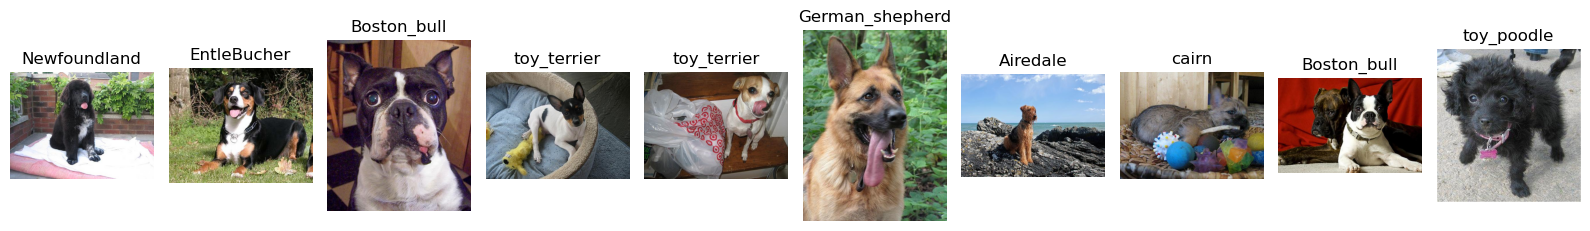

In [13]:
# 샘플 이미지 출력
show_sample_images(IMAGES_DIR, 10)

In [14]:
# 데이터 전처리 설정 -> 데이터 인스턴스에 전달
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
        transforms.ToTensor(), # 텐서로 변환 (0~1 범위)
        transforms.Lambda(lambda x: torch.clamp(x, 0, 1)), # 안전장치로 clamp 설정
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ResNet 전용 정규화 값
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [15]:
# 데이터셋 인스턴스 생성
train_dataset = StanfordDogsDataset(
    img_dir=IMAGES_DIR,
    list_path=TRAIN_LIST_PATH,
    transform=data_transforms['train']
)

val_dataset = StanfordDogsDataset(
    img_dir=IMAGES_DIR, 
    list_path=TEST_LIST_PATH, 
    transform=data_transforms['val']
)

print(f"✅ 학습 데이터: {len(train_dataset)}개 | 검증 데이터: {len(val_dataset)}개") # Sanity check

✅ 학습 데이터: 12000개 | 검증 데이터: 8580개


## 4. 증강 기법 시각화

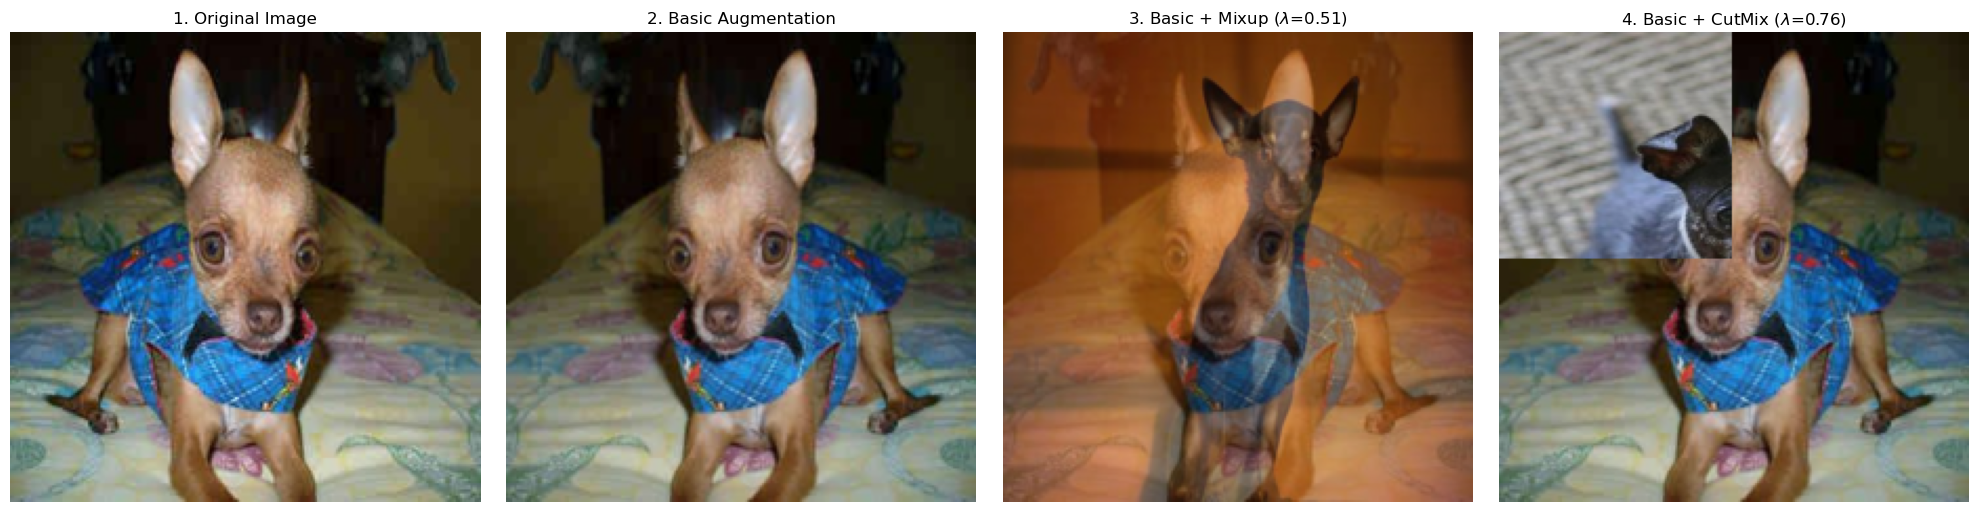

In [16]:
# 시각화할 인덱스 고정
TARGET_IDX = 0 
BATCH_SIZE = 8

# 원본 이미지 파일 경로 가져오기
row = train_dataset.img_labels.iloc[TARGET_IDX]
img_filename = row.iloc[0] # .iloc로 위치 기반 접근 명시
sample_path = os.path.join(train_dataset.img_dir, img_filename)

# Case 1: 원본 (Transform 적용 전)
raw_img_pil = Image.open(sample_path).convert('RGB').resize((224, 224))

# DataLoader에서 배치 가져오기 (이미 Standard Aug 적용됨)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # Shuffle 끄기
images_batch, labels_batch = next(iter(train_loader))

# Case2: 배치 가져올 때 이미 적용됨

# Case 3: 기본 증강 + Mixup (기본 증강 적용된 배치에 apply_mixup 함수 적용)
mixup_imgs, _, lam_mix = apply_mixup(images_batch.clone(), labels_batch, alpha=0.85) # 원본 보존을 위해 .clone() 사용

# Case 4: 기본 증강 + CutMix (기본 증강 적용된 배치에 apply_cutmix 함수 적용)
cutmix_imgs, _, lam_cut = apply_cutmix(images_batch.clone(), labels_batch, alpha=0.85)

# 시각화
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(raw_img_pil)
plt.title("1. Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(denormalize(images_batch[TARGET_IDX]).permute(1, 2, 0).cpu())
plt.title("2. Basic Augmentation")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(denormalize(mixup_imgs[TARGET_IDX]).permute(1, 2, 0).cpu())
plt.title(fr"3. Basic + Mixup ($\lambda$={lam_mix:.2f})")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(denormalize(cutmix_imgs[TARGET_IDX]).permute(1, 2, 0).cpu())
plt.title(fr"4. Basic + CutMix ($\lambda$={lam_cut:.2f})")
plt.axis('off')

plt.tight_layout()
plt.show()

## 5. 실험 진행

In [21]:
# 하이퍼파라미터 및 장치 설정
NUM_CLASSES = 120
BATCH_SIZE = 32 # 컨테이너 메모리 용량 부족으로 작게 설정
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda



🚀 Starting Experiment: No Aug
Epoch [1/10]: Loss 2.0087 | Top-1 71.10% | Top-5 95.40% | Time 76.8s
   >>> ★ New best model saved: best_model_No_Aug.pth
Epoch [2/10]: Loss 0.7779 | Top-1 73.81% | Top-5 95.48% | Time 74.2s
   >>> ★ New best model saved: best_model_No_Aug.pth
Epoch [3/10]: Loss 0.5041 | Top-1 74.58% | Top-5 95.99% | Time 74.2s
   >>> ★ New best model saved: best_model_No_Aug.pth
Epoch [4/10]: Loss 0.3375 | Top-1 73.41% | Top-5 95.61% | Time 74.1s
Epoch [5/10]: Loss 0.2469 | Top-1 72.54% | Top-5 95.61% | Time 74.3s
Epoch [6/10]: Loss 0.1837 | Top-1 72.00% | Top-5 94.62% | Time 74.4s
Epoch [7/10]: Loss 0.1790 | Top-1 71.90% | Top-5 94.11% | Time 74.2s
Epoch [8/10]: Loss 0.1552 | Top-1 73.34% | Top-5 94.84% | Time 74.5s
Epoch [9/10]: Loss 0.1146 | Top-1 73.21% | Top-5 94.76% | Time 74.2s
Epoch [10/10]: Loss 0.1285 | Top-1 70.69% | Top-5 93.26% | Time 74.2s

🚀 Starting Experiment: Basic Aug
Epoch [1/10]: Loss 1.9960 | Top-1 70.05% | Top-5 95.63% | Time 74.5s
   >>> ★ New bes

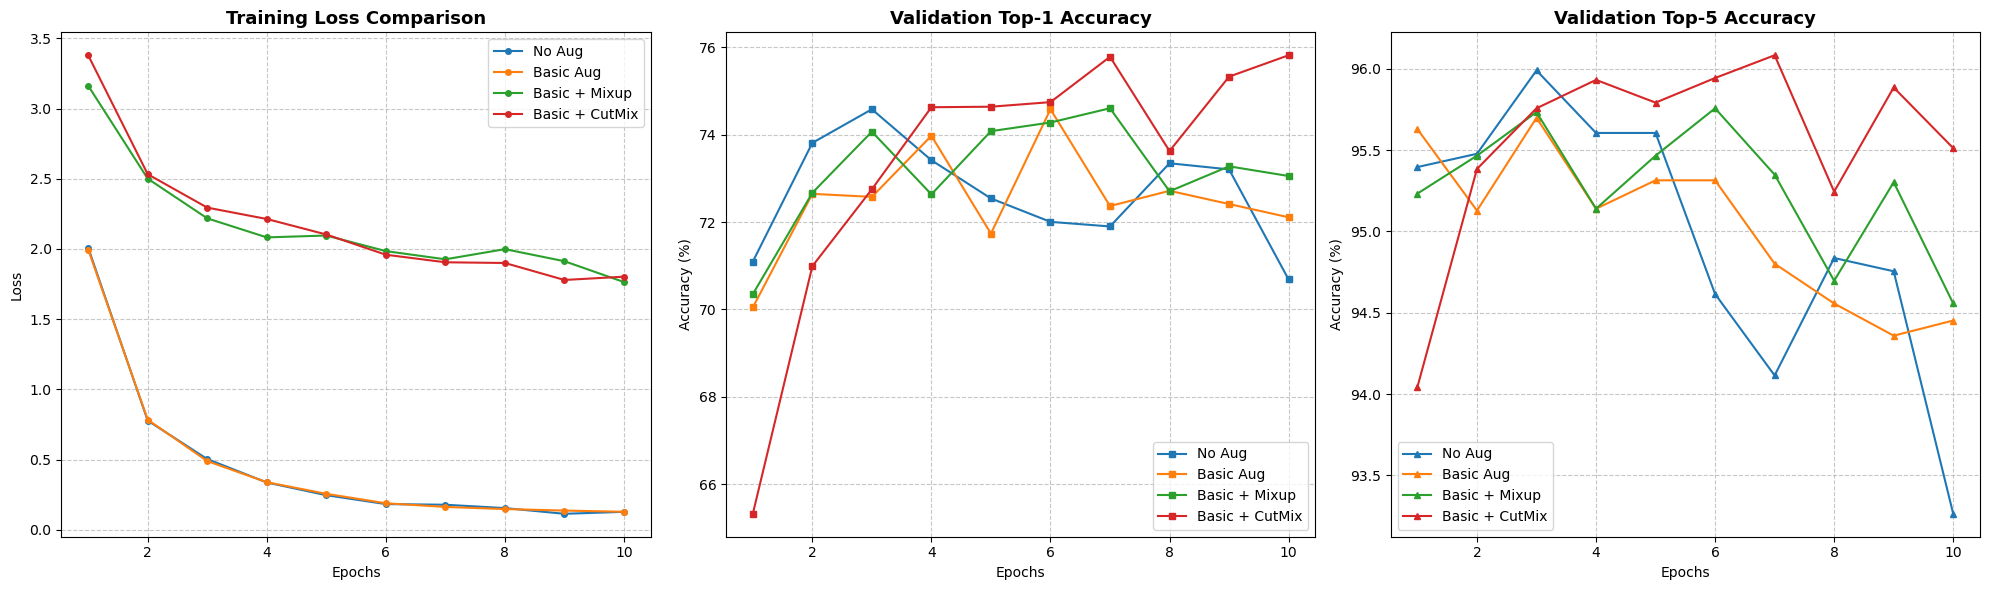

In [22]:
train_data = StanfordDogsDataset(
    img_dir=IMAGES_DIR,
    list_path=TRAIN_LIST_PATH,
    transform=data_transforms['train']
)

val_data = StanfordDogsDataset(
    img_dir=IMAGES_DIR, 
    list_path=TEST_LIST_PATH, 
    transform=data_transforms['val']
)


# 각 실험군 실행 (configs 리스트에서 trans 인자 제거)
results = {}
configs = [
    ('No Aug', None, 1.0), # aug_type만 명시
    ('Basic Aug', None, 1.0),
    ('Basic + Mixup', 'mixup', 0.85),
    ('Basic + CutMix', 'cutmix', 0.85)
]

# 캐시 삭제
torch.cuda.empty_cache()

for name, aug, alpha_val in configs:
    # 💡 루프 시작 시 train_dataset의 transform만 동적으로 변경
    if name == 'No Aug':
        # No Aug 실험 시 train_dataset의 transform을 'val' transform으로 일시 변경
        train_dataset.transform = data_transforms['val']
    else:
        # 그 외 실험은 'train' transform 사용
        train_dataset.transform = data_transforms['train']
    
    # DataLoader 생성 
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
    
    results[name] = run_experiment(
        exp_name=name, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        save_dir=SAVE_DIR,
        aug_type=aug, 
        alpha=alpha_val
    )

# 모든 실험 종료 후 시각화 함수 호출
visualize_results(results)

## 6. 실험 결과

## 7. 회고